In [1]:
#IMPORTS
#Install+Import Packages
!pip install mechanize
import random
import re
import mechanize
import numpy as np
from random import *
import matplotlib.pyplot as plt
!pip install Bio
from Bio import SeqIO
from Bio.Seq import Seq
from collections import Counter 
from Bio.Cluster import kcluster
import statistics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import difflib
import seaborn as sns; sns.set_theme()
from collections import defaultdict
import collections
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from collections import OrderedDict
import matplotlib.pyplot as plt
from itertools import filterfalse
from matplotlib.pyplot import figure
import scipy.stats as stats
import pylab
from itertools import permutations
#!pip install ipython-autotime

In [2]:
#Upload Data and Define Parameters
leu_aa = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/Leu_S5_L001_R1_001.fastq').readlines()
ala_aa = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/Ala_S3_L001_R1_001.fastq').readlines()
gly_aa = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/Gly_S1_L001_R1_001.fastq').readlines()
phe_aa = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/Phe_S7_L001_R1_001.fastq').readlines()

leu_rna = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/LeuNaOH_S6_L001_R1_001.fastq').readlines()
ala_rna = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/AlaNaOH_S4_L001_R1_001.fastq').readlines()
gly_rna = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/GlyNaOH_S2_L001_R1_001.fastq').readlines()
phe_rna = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/PheNaOH_S8_L001_R1_001.fastq').readlines()

ctrl_8a = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/8actrl_S9_L001_R1_001.fastq').readlines()
ctrl_5b = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/5bctrl_S10_L001_R1_001.fastq').readlines()


In [3]:
#Upload Data and Define Parameters
file_type = '.fastq'

#Take the reverse complement? Enter 'yes' or 'no'
rc = 'no'

#Quality Cutoff - what fraction of positions should have <1% error probability?
quality_cutoff = 0.9


#Position motif1 starts at
motif_start = 1
#Motif1 define
motif = 'AAAGCCTG'
#Position motif2 starts at
motif2_start = 21
#Motif2 define
motif2 = 'TAGGCAAAAGATCGGAAGAGCACACGTCT'

In [4]:
def preprocess_seqs(list_of_seqs):

    if file_type == '.fastq':
        seqs = list_of_seqs[1::4]
        qualities = list_of_seqs[3::4]
        print('Total seqs: '+str(len(seqs)))

        #Filter by quality
        high_quality = []
        acceptable_quals_1_percent_error = [5,6,7,8,9,':',';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
        for seq in range(len(qualities)):
            overlap=0
            for char in list(set(qualities[seq]).intersection(acceptable_quals_1_percent_error)):
                overlap+=qualities[seq].count(char)
            if overlap/len(qualities[1])>quality_cutoff:
                high_quality.append(seqs[seq].strip("\n"))
        print('High quality seqs: '+str(len(high_quality)))
    
    if file_type == '.fasta':
        high_quality = list_of_seqs[1::2]
        print('Total seqs: '+str(len(high_quality)))
    
    #Take RC if desired
    pre_trim = []
    if rc == 'yes':
        rc_seqs = []
        for sequence in high_quality:
            rc_seqs.append(str(Seq(sequence).reverse_complement()).strip('\n'))
        pre_trim = rc_seqs
    else:
        for sequence in high_quality:
            pre_trim.append(str(Seq(sequence)).strip('\n'))
    if rc == 'yes':
        print('Reverse Comp = '+str(rc)) 

    #Trim to keep only seqs with constant region
    trimmed = []
    for seq in pre_trim:
        if motif in seq:
            if motif2 in seq:
                trimmed.append('GCCTG'+seq[(motif_start-1)+len(motif):(motif2_start-1)]+'TAGGC')
    print('Seqs after trimming: '+str(len(trimmed))) 
    
    #All processed seqs
    processed_seqs = trimmed
    #Unique seqs
    processed_seqs_unique = list(set(trimmed))
    
    return processed_seqs, processed_seqs_unique


def rscape_format(title, num_seqs_to_analyze, top_seqs):
    #Create file for R-Scape Covariation
    f = open("/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/"+str(title)+".txt", "w")
    f.write('# STOCKHOLM 1.0\n')
    f.write('\n')
    counter = 0
    for seq in top_seqs[:num_seqs_to_analyze]:
      counter+=1
      f.write(str(counter)+'\t'+seq[0]+'\n')
    #f.write('#=GC SS_cons	(((((((((,)))))))))\n')
    f.write('//')

def get_info(aa, rna, title):
    print(title)
    print('AA ONLY:')
    aa_ctrl_processed_seqs, aa_ctrl_processed_seqs_unique = preprocess_seqs(aa)
    aa_ctrl_top_seqs = Counter(aa_ctrl_processed_seqs).most_common(100)
    print('Unique AA seqs '+str(len(aa_ctrl_processed_seqs_unique)))
    print(aa_ctrl_top_seqs[:10])
    print('RNA ONLY:')
    rna_ctrl_processed_seqs, rna_ctrl_processed_seqs_unique = preprocess_seqs(rna)
    rna_ctrl_top_seqs = Counter(rna_ctrl_processed_seqs).most_common(100)
    print('Unique RNA seqs '+str(len(rna_ctrl_processed_seqs_unique)))
    print(rna_ctrl_top_seqs[:10])
    aa_rna_no_overlap = list(filterfalse(set(rna_ctrl_processed_seqs).__contains__, aa_ctrl_processed_seqs))
    print('AA NOT RNA: '+str(round(len(aa_rna_no_overlap))))
    aa_not_rna_top_seqs = Counter(aa_rna_no_overlap).most_common(10000)
    print('Unique AA only seqs '+str(len(set(aa_rna_no_overlap))))
    top_seqs = aa_not_rna_top_seqs[:10]
    rscape_format(title+'_rscape_1000',1000, aa_not_rna_top_seqs)
    print('R-Scape file saved')
    return aa_ctrl_processed_seqs, rna_ctrl_processed_seqs, aa_rna_no_overlap, aa_ctrl_top_seqs, rna_ctrl_top_seqs, aa_not_rna_top_seqs, top_seqs

In [5]:
gly_aa_ctrl_processed_seqs, gly_rna_ctrl_processed_seqs, gly_aa_rna_no_overlap, gly_aa_ctrl_top_seqs, gly_rna_ctrl_top_seqs, gly_aa_not_rna_top_seqs, gly_top_seqs = get_info(gly_aa, gly_rna, 'Gly')
print('')
leu_aa_ctrl_processed_seqs, leu_rna_ctrl_processed_seqs, leu_aa_rna_no_overlap, leu_aa_ctrl_top_seqs, leu_rna_ctrl_top_seqs, leu_aa_not_rna_top_seqs, leu_top_seqs = get_info(leu_aa, leu_rna, 'Leu')
print('')
phe_aa_ctrl_processed_seqs, phe_rna_ctrl_processed_seqs, phe_aa_rna_no_overlap, phe_aa_ctrl_top_seqs, phe_rna_ctrl_top_seqs, phe_aa_not_rna_top_seqs, phe_top_seqs = get_info(phe_aa, phe_rna, 'Phe')
print('')
ala_aa_ctrl_processed_seqs, ala_rna_ctrl_processed_seqs, ala_aa_rna_no_overlap, ala_aa_ctrl_top_seqs, ala_rna_ctrl_top_seqs, ala_aa_not_rna_top_seqs, ala_top_seqs = get_info(ala_aa, ala_rna, 'Ala')


Gly
AA ONLY:
Total seqs: 356811
High quality seqs: 347603
Seqs after trimming: 216113
Unique AA seqs 153628
[('GCCTGGGGGGTAGGCAATAGGC', 31), ('GCCTGGGTGGTAGGCAATAGGC', 29), ('GCCTGTTATGGGAGTAATAGGC', 28), ('GCCTGGGGGTAGGCAAATAGGC', 27), ('GCCTGATGTGGGAATGTTAGGC', 26), ('GCCTGTTTGTAGGTAGATAGGC', 26), ('GCCTGATAGTGGGGTGTTAGGC', 24), ('GCCTGATTGTAGGGGGTTAGGC', 24), ('GCCTGGATTGGGAGGTTTAGGC', 24), ('GCCTGAATGTGGGGGTTTAGGC', 24)]
RNA ONLY:
Total seqs: 574755
High quality seqs: 551138
Seqs after trimming: 332641
Unique RNA seqs 211879
[('GCCTGGTGGTAGGCAAATAGGC', 784), ('GCCTGGTAGGCAAAAGATAGGC', 739), ('GCCTGGTATTAGGCAAATAGGC', 609), ('GCCTGGGTGGTAGGCAATAGGC', 575), ('GCCTGGGGGGTAGGCAATAGGC', 525), ('GCCTGGGGGGGTAGGCATAGGC', 514), ('GCCTGGGGGGTTAGGCATAGGC', 505), ('GCCTGGGGGTAGGCAAATAGGC', 468), ('GCCTGGTGTTAGGCAAATAGGC', 449), ('GCCTGGTGTAGGCAAAATAGGC', 440)]
AA NOT RNA: 144422
Unique AA only seqs 118777
R-Scape file saved

Leu
AA ONLY:
Total seqs: 239837
High quality seqs: 233354
Seqs after

In [9]:
#UPDATES 4/2/22
#Make control datasets
ctrl_8a_subseqs = []
for sub_seq in ctrl_8a[1::4]:
    ctrl_8a_subseqs.append(sub_seq[8:14])
expected_8a = len(ctrl_8a_subseqs)*0.25**6
print('First 6, expected reads of any subseq: '+str(round(expected_8a,2)))

ctrl_5b_subseqs = []
for sub_seq in ctrl_5b[1::4]:
    ctrl_5b_subseqs.append(sub_seq[3:9])
expected_5b = len(ctrl_5b_subseqs)*0.25**6
print('Second 6, expected reads of any subseq: '+str(round(expected_5b,2)))

#Find enrichment for each sequence
aa_not_rna_top_seqs = gly_aa_not_rna_top_seqs

aa_list =[gly_aa_not_rna_top_seqs, leu_aa_not_rna_top_seqs, phe_aa_not_rna_top_seqs, ala_aa_not_rna_top_seqs]
all_sorted_seqs = []
for aa_not_rna_top_seqs in aa_list:
    print('AA'+str(1+aa_list.index(aa_not_rna_top_seqs)))
    sequences_enrichments = []
    counter=0
    for seq in aa_not_rna_top_seqs:
        counter+=1
        if counter%1000==0:
            print(str(counter)+'/'+str(len(aa_not_rna_top_seqs)))
        first_6 = seq[0][5:11]
        second_6 = seq[0][11:17]
        enrichment_first_6 = ctrl_8a_subseqs.count(first_6)/expected_8a
        enrichment_second_6 = ctrl_5b_subseqs.count(second_6)/expected_5b
        enrichment = round(enrichment_first_6*enrichment_second_6,2)
        sequences_enrichments.append([seq[0], seq[1], enrichment, seq[1]/enrichment])
    sorted_seqs = sorted(sequences_enrichments, key=lambda x: x[-1])[::-1]
    all_sorted_seqs.append(sorted_seqs)
    rscape_format('AA'+str(1+aa_list.index(aa_not_rna_top_seqs)), 1000, sorted_seqs)
    print(sorted_seqs[:10])

First 6, expected reads of any subseq: 155.42
Second 6, expected reads of any subseq: 201.08
AA1
1000/10000
2000/10000
3000/10000
4000/10000
5000/10000
6000/10000
7000/10000
8000/10000
9000/10000
10000/10000
[['GCCTGTATCCGAGTATATAGGC', 2, 0.14, 14.285714285714285], ['GCCTGTTCTATCTGAACTAGGC', 2, 0.15, 13.333333333333334], ['GCCTGTAATGCATATTATAGGC', 5, 0.42, 11.904761904761905], ['GCCTGGATCTCTCTGATTAGGC', 2, 0.17, 11.76470588235294], ['GCCTGTACGATACGTTATAGGC', 3, 0.28, 10.714285714285714], ['GCCTGAATCGAGAGAATTAGGC', 2, 0.2, 10.0], ['GCCTGAATTTCGCAATTTAGGC', 3, 0.31, 9.67741935483871], ['GCCTGAGAGTGGAACCTTAGGC', 2, 0.22, 9.090909090909092], ['GCCTGTAAAGTCATTTATAGGC', 4, 0.44, 9.090909090909092], ['GCCTGAATATTGTAATTTAGGC', 3, 0.33, 9.09090909090909]]
AA2
1000/10000
2000/10000
3000/10000
4000/10000
5000/10000
6000/10000
7000/10000
8000/10000
9000/10000
10000/10000
[['GCCTGCTCCTCCCCAGGTAGGC', 1, 0.02, 50.0], ['GCCTGCGTTCCCCCGCGTAGGC', 1, 0.03, 33.333333333333336], ['GCCTGGACAACCACCTCTAGGC', 

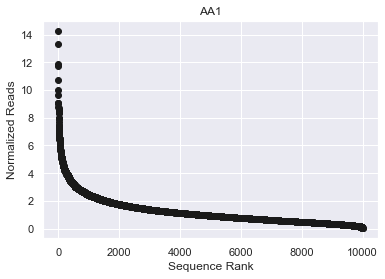

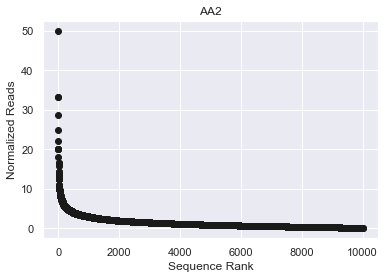

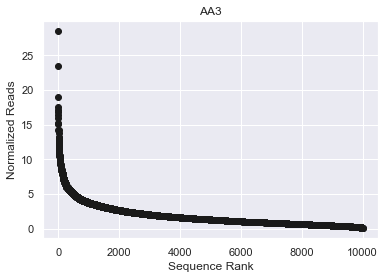

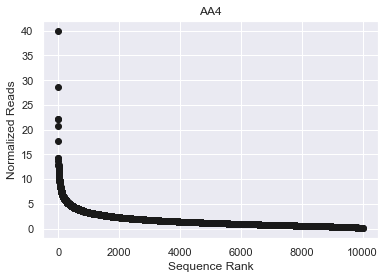

In [10]:
#Suterland Plots
for aa in all_sorted_seqs:
    all_reads = []
    for seq in aa:
      all_reads.append(seq[3])
    all_reads = sorted(all_reads)[::-1]
    plt.scatter(range(1, 1+len(all_reads)), all_reads, color = 'k')
    plt.xlabel('Sequence Rank')
    plt.ylabel('Normalized Reads')
    plt.title('AA'+str(1+all_sorted_seqs.index(aa)))
    plt.show()
    num = 100
    rscape_format('AA'+str(1+all_sorted_seqs.index(aa))+str(num), num, aa)